In [3]:
import sys
sys.path.append('../')

In [ ]:
import torch

a = torch.tensor([1,2])
a.cuda()

## INFERENCE

In [ ]:
from my_utils.datasets import *
import cv2
import numpy as np
from models import Darknet
import torch
from torchvision import transforms as transforms
import torchvision

img_size = 512
file_name = '/home/lrh/program/git/object_detection/code/yolov3-train/asserts/img_17247.jpg'
img0 = cv2.imread(file_name)
img = letterbox(img0, new_shape=img_size)[0]
#img = img / 255.0
print(img.shape)
img = img[:, :, ::-1]  # BGR to RGB, to 3x416x416
#img = np.ascontiguousarray(img)
img = transforms.ToTensor()(np.array(img))
img = img.unsqueeze(0).cuda()


model = Darknet('../trained_models/baseline-stitcher/yolov3-spp-44.cfg', img_size=img_size)
model.load_state_dict(torch.load('../trained_models/baseline-stitcher/best.pt')['model'])
model = model.cuda()
model.eval()

torchvision.utils.save_image(img, 'input.jpg')

img_test = torch.zeros((1, 3, img_size, img_size)).cuda()
model(img_test)

pred = model(img)[0]

print(pred[0,:4,:4])


## VAL DATASET

command: python3 test.py --cfg trained_models/yolov3-spp-default/yolov3-spp-44.cfg --data data/rubbish.data --weights trained_models/yolov3-spp-default/best.pt --batch-size 8

## 上述计算AP_s, AP_m, AP_l可能有问题，下面重新尝试计算

### 1. model outputs

In [ ]:
import json

from torch.utils.data import DataLoader

from models import *
from my_utils.datasets import *
from my_utils.utils import *

## python3 test.py --cfg yolov3-44.cfg --data data/rubbish.data --weights trained_models/yolo-v3-60e/best.pt --batch-size 8

def test(cfg,
         data,
         weights=None,
         batch_size=1,
         imgsz=512,
         conf_thres=0.001,
         iou_thres=0.6,  # for nms
         save_json=False,
         single_cls=False,
         augment=False,
         model=None,
         dataloader=None):
    # Initialize/load model and set device
    if model is None:
        device = torch_utils.select_device('cuda', batch_size=batch_size)
        verbose = True

        # Remove previous
        for f in glob.glob('test_batch*.jpg'):
            os.remove(f)

        # Initialize model
        model = Darknet(cfg, imgsz)

        # Load weights
        attempt_download(weights)
        if weights.endswith('.pt'):  # pytorch format
            model.load_state_dict(torch.load(weights, map_location=device)['model'])
        elif weights.endswith('.pkl'):
            model.load_state_dict(torch.load(weights, map_location=device))
        else:  # darknet format
            load_darknet_weights(model, weights)

        # Fuse
        model.fuse()
        model.to(device)

        if device.type != 'cpu' and torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    else:  # called by train.py
        device = next(model.parameters()).device  # get model device
        verbose = False

    # Configure run
    data = parse_data_cfg(data)
    nc = 1 if single_cls else int(data['classes'])  # number of classes
    path = data['valid']  # path to test images
    names = load_classes(data['names'])  # class names
    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if dataloader is None:
        dataset = LoadImagesAndLabels(path, imgsz, batch_size, rect=True, single_cls=False)
        batch_size = min(batch_size, len(dataset))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]),
                                pin_memory=True,
                                collate_fn=dataset.collate_fn)

    seen = 0
    model.eval()
    _ = model(torch.zeros((1, 3, imgsz, imgsz), device=device)) if device.type != 'cpu' else None  # run once
    s = ('%20s' + '%10s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@0.5', 'F1')
    p, r, f1, mp, mr, map, mf1, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0.
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class = [], [], [], []
    
    outputs = []
    
    for batch_i, (imgs, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
        
        imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        nb, _, height, width = imgs.shape  # batch size, channels, height, width
        whwh = torch.Tensor([width, height, width, height]).to(device)

        # Disable gradients
        with torch.no_grad():
            # Run model
            t = torch_utils.time_synchronized()
            inf_out = model(imgs, augment=augment)[0]  # inference and training outputs
            t0 += torch_utils.time_synchronized() - t
            # Run NMS
            t = torch_utils.time_synchronized()
            ## output:
            ### list data for each images: (nx6 (x1, y1, x2, y2, conf, cls))
            output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres)  # nms
            t1 += torch_utils.time_synchronized() - t
            """
            output with type(list) and shape:
                n * 6 (xyxy， confidence, pcls)
            """
            
            # [{"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78], "score": 0.236}, ...
            for si, pred in enumerate(output):
                ## 对于每张图片
                pred = pred.clone()
                temp = {
                    'pred': pred[:, :4].tolist(), ## 输出bbox
                    'conf': pred[:,4].tolist(),## object confidence.
                    'preid': pred[:, -1].tolist(), ## 输出类别
                    'whwh': whwh.clone().tolist(), ## 输入图像大小
                    'target': targets[targets[:, 0] == si,1:].clone().tolist(), ##目标gt [cls, xyhw]
                    'path': paths[si],
                    'shapes': shapes[si] #原始图像大小
                }
                
                outputs.append(temp)
                
    return outputs

cfg = '../trained_models/baseline-stitcher/yolov3-spp-44.cfg'
data = '../data/rubbish.data' 
weights = '../trained_models/baseline-stitcher/best.pt'
#data/rubbish.data --weights trained_models/yolov3-spp-default/best.pt
batch_size = 1
#data/rubbish.data --weights trained_models/yolov3-spp-default/best.pt

outputs = test(cfg, data, weights, batch_size)

### 2. save & load output

In [ ]:
# print(len(outputs))
# for key in outputs[0].keys():
#     print(type(outputs[0][key]))
with open('stitcher.output.json', 'w') as f:
    json.dump(outputs, f)

In [9]:
import sys
sys.path.append('../')
import json

## 读取类标
from my_utils.utils import *
class_names = load_classes('/store/dataset/rubbish_yolo/classes.names')
print(class_names)

with open('stitcher.output.json','r') as f:
    outputs = json.load(f)
    
print(len(outputs))

['一次性快餐盒', '书籍纸张', '充电宝', '剩饭剩菜', '包', '垃圾桶', '塑料器皿', '塑料玩具', '塑料衣架', '大骨头', '干电池', '快递纸袋', '插头电线', '旧衣服', '易拉罐', '枕头', '果皮果肉', '毛绒玩具', '污损塑料', '污损用纸', '洗护用品', '烟蒂', '牙签', '玻璃器皿', '砧板', '筷子', '纸盒纸箱', '花盆', '茶叶渣', '菜帮菜叶', '蛋壳', '调料瓶', '软膏', '过期药物', '酒瓶', '金属厨具', '金属器皿', '金属食品罐', '锅', '陶瓷器皿', '鞋', '食用油桶', '饮料瓶', '鱼骨']
1497


### 3. 计算AP small, medium, large, all.

In [5]:
import torch
import numpy as np
from my_utils.utils import *
# Statistics per image
#obj_size_label 
## 0: SMALL, 1: MEDIUM, 2: LARGE, other: ALL
#obj_size_label = 'medium'

iouv = torch.linspace(0.5, 0.95, 10) # iou vector for mAP@0.5:0.95
iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
niou = iouv.numel()


def select_with_size(*args, size_label='small', input_format='xyxy'):
    
    targets = args[0]
    
    if input_format == 'xywh':
        target_size = targets[:, 3] * targets[:, 2]
    else:
        target_size = (targets[:, 3] - targets[:, 1]) * (targets[:, 2] - targets[:, 0])
    
    if size_label == 'small':
        target_size_ind = np.where(target_size < 0.1)
    elif size_label == 'medium':
        target_size_ind = np.where((target_size> 0.1) & (target_size <0.3))
    elif size_label == 'large':
        target_size_ind = np.where(target_size> 0.3)
    else:
        ##所有样本
        target_size_ind = np.where(target_size>=0)
    
    return [arg[target_size_ind] for arg in args]

def calculate_AP_size(outputs, obj_size_label):

    stats = []
    paths = []
    ## 对于每一个图像数据
    for si, output in enumerate(outputs):
        ## 准备数据 targets [cls_label, xywh]
        targets = torch.tensor(output['target'])
        ## pred: xyxy
        pred = torch.tensor(output['pred'])
        conf = torch.tensor(output['conf'])
        pred_cls = torch.tensor(output['preid'])
        whwh = torch.tensor(output['whwh'])
        path = output['path']


        ## 筛选
        ### tboxs = targets[:, 1:5] tlables = targets[:, 0]
        tboxs, tlabels = select_with_size(targets[:, 1:5], targets[:, 0], size_label = obj_size_label, input_format='xywh')
        pboxs, pconfs, plabels = select_with_size(pred/whwh, conf, pred_cls, size_label = obj_size_label, input_format='xyxy')

        pboxs = pboxs * whwh

        #print(pboxs.shape)
        ## 计算图像i中obj个数
        nl = len(tlabels)
        ## 将target类标转成list格式
        #tcls = labels[:, 0].tolist() if nl else []  # target class

        # Clip boxes to image bounds
        # 将输出 clip 到图像大小
        #print(pboxs[0])
        clip_coords(pboxs, whwh[1:3])
        #print(pboxs[0])

        # Assign all predictions as incorrect
        ## correct: [pred.shape[0], niou] => [[False]] 
        correct = torch.zeros(pboxs.shape[0], niou, dtype=torch.bool)
        ## 如果有框
        if nl:
            detected = []  # target indices
            #tcls_tensor = tlabels[:, 0]

            # target boxes
            ## 目标框xyxy × whwh
            tbox = xywh2xyxy(tboxs) * whwh

            # Per target class
            for cls in torch.unique(tlabels):
                
#                 if(cls==7):
#                     print(tlabels)
#                     print(tboxs)
                
                ## 目标target=>类标为cls的位置
                ti = (cls == tlabels).nonzero().view(-1)  # prediction indices
                ## 预测pred=>类标为cls的位置
                pi = (cls == plabels).nonzero().view(-1)  # target indices

                # Search for detections
                if pi.shape[0]:
                    # Prediction to target ious
                    ## 计算框之间的 iou
                    ## shape if pred:torch.Size([9, 6]), 
                    ## shape of target:torch.Size([1, 4]), 
                    ## shape of ious:torch.Size([9]) => 表示预测框与target之间的最大交集区域的iou
                    ## shape of i: torch.Size([9]) => 表示匹配的目标框位置。
                    ious, i = box_iou(pboxs[pi], tbox[ti]).max(1)  # best ious, indices
    #                         print("shape if pred:{}, shape of target:{}, shape of ious:{}".format(
    #                             pred[pi].shape, tbox[ti].shape, ious.shape))
                    #print("value in ious:", ious)
                    # Append detections
                    ## 对于所有 与 gt 之间iou 大于0.5的框 
                    ## iouv = [0.5]
                    for j in (ious > iouv[0]).nonzero():
                        ## j 表示有效框
                        d = ti[i[j]]  # detected target
                        ## 对于所有目标框, 找到
                        if d not in detected:
                            detected.append(d)
                            ## 如果预测的框 pi[j] 与 ti[i[j]] 交集 iou 大于iouv 则认为检测正确

                            correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                            if len(detected) == nl:  # all targets already located in image
                                break

        # Append statistics (correct, conf, pcls, tcls)
        ### correct: [pred_shape, iouv] 在指定 iou threshod 下，检测到的框是否是正确的
        stats.append((correct.cpu(), pconfs.cpu(), plabels.cpu(), tlabels.cpu()))
        #paths.append(path)

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    return stats


## yolo-spp

small: 0.30785361123913974

medium: 0.5442876200412141

large: 0.792296026933334

all: 0.7025410264942612

## yolo-spp-stitcher

small: 0.40560762181863386

medium: 0.6365985867921662

large: 0.8118037199254308

all: 0.7263963434704765

In [11]:
size_levels = ['small', 'medium', 'large', 'all']
mAPs = np.zeros([len(class_names), 0])

for size_level in size_levels:
    ## Compute mAP.
    stats = calculate_AP_size(outputs = outputs, obj_size_label = size_level)
    #print(stats[3])
    from my_utils.utils import *
    niou = 1
    nc = 44  # number of classes
    if len(stats):
        p, r, ap, f1, ap_class = ap_per_class(*stats)
        if niou > 1:
            p, r, ap, f1 = p[:, 0], r[:, 0], ap.mean(1), ap[:, 0]  # [P, R, AP@0.5:0.95, AP@0.5]
        mp, mr, map, mf1 = p.mean(), r.mean(), ap.mean(), f1.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    
    ap = ap.squeeze()
    
    print(map)
    
    if size_level == 'small':
        ap = np.insert(ap, 4, np.nan)
        ap = np.insert(ap, 8, np.nan)
#         ap = np.insert(ap, 9, np.nan)
#         ap = np.insert(ap, 15, np.nan)
#         ap = np.insert(ap, 34, np.nan)
    elif size_level == 'medium':
        ap = np.insert(ap, 13, np.nan)
#         ap = np.insert(ap, 4, np.nan)
#         ap = np.insert(ap, 22, np.nan)
    #print(ap.squeeze().shape)
    #print("mp, mr, map, mf1", mp, mr, map, mf1)
    
    mAPs = np.concatenate((mAPs, ap[:,np.newaxis]), axis=1)

#     for i in range(ap.shape[0]):
#         print(ap[i])
print(mAPs.shape)

    #print(ap[ap!=0].mean())

0.40560762181863386
0.6365985867921662
0.8118037199254308
0.7263963434704765
(44, 4)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[    0.22408     0.29113     0.34882     0.39227     0.39562     0.56377     0.57309     0.60211     0.60271      0.6363     0.63786     0.65587     0.65628     0.67841      0.6796     0.70641     0.74758     0.74876     0.75486     0.75556     0.75948     0.76344      0.7716     0.77344     0.77477     0.78654
     0.80684     0.81325     0.81448     0.82346     0.83008     0.83822      0.8385     0.84477     0.87654     0.87904     0.88525     0.89319     0.89329     0.91612     0.92278     0.92389     0.94063     0.94073]


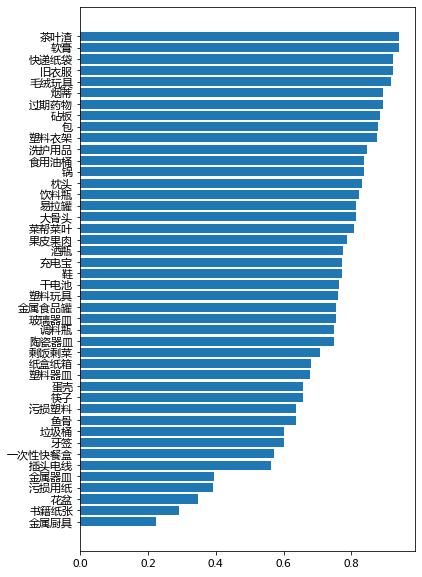

In [42]:
index = np.argsort(mAPs[:, -1])
mAPs[index]
np.array(class_names)[index]
x = np.arange(len(class_names))
print(x)
from matplotlib import pyplot as plt
print(mAPs[index][:,-1])
plt.figure(figsize=(6,10))
plt.barh(x, mAPs[index][:,-1])
plt.yticks(x, np.array(class_names)[index])
plt.show()

### 4. 统计不同类别不同size大小的个数（验证集）

In [12]:
import numpy as np

targets = np.zeros([0,5])
for si, output in enumerate(outputs):
    target = np.array(output['target'])
    targets = np.concatenate((targets, target), axis=0)

size_levels = ['small', 'medium', 'large', 'all']
## 44 * 3
size_nums = np.zeros([len(class_names), len(size_levels)])
## cls, xywh
#print(targets[0])

for i, class_name in enumerate(class_names):
    for sind, size_level in enumerate(size_levels):
        target = select_with_size(targets[targets[:, 0] == i,1:], size_label=size_level, input_format='xywh')[0]
        size_nums[i, sind] = target.shape[0]
#print(size_nums)

# targets_temp = targets[targets[:, 0] == 7,1:]

results = np.concatenate((size_nums, mAPs), axis=1)

for index, result in enumerate(results):
    print(index,'-',class_names[index].ljust(9 - len(class_names[index])), ':', result)
    #print(len(class_names[index]))
# print(targets_temp)

# target = select_with_size(targets_temp, size_label='small', input_format='xywh')[0]
# print(target)    

0 - 一次性快餐盒 : [          9           7          14          30    0.013228     0.49996     0.79942     0.57309]
1 - 书籍纸张  : [          4           3           9          16           0       0.122     0.56141     0.29113]
2 - 充电宝    : [          6          17          25          48     0.17607     0.70197     0.87459     0.77344]
3 - 剩饭剩菜  : [        134          23          17         174      0.6623     0.70682     0.80469     0.70641]
4 - 包        : [          0           1          39          40         nan       0.995     0.92582     0.87904]
5 - 垃圾桶    : [          1           5           9          15      0.4975     0.39514     0.72707     0.60271]
6 - 塑料器皿  : [         14          16          35          65     0.16434     0.63821     0.87524     0.67841]
7 - 塑料玩具  : [          1          23          20          44       0.995       0.611     0.90179     0.75948]
8 - 塑料衣架  : [          0           9          24          33         nan     0.58105     0.90014     0.87654]
9 - 

### 5. 查看结果比较差的类的可视化结果

tbox: xywh

pbox: xyxy

[    0.28508   0.0015595   0.0011667]


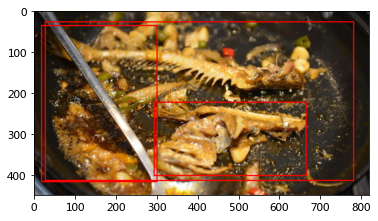

[    0.19167     0.11763     0.02976    0.018945   0.0090342   0.0066909   0.0040228   0.0022154]


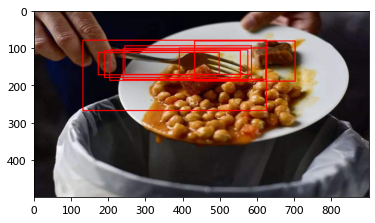

[     0.5714   0.0032764   0.0026571   0.0014207   0.0010472]


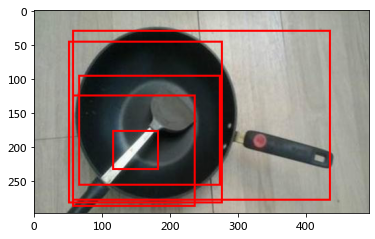

[    0.18053     0.10839    0.084547    0.074848     0.02973    0.018568    0.016186    0.010743   0.0088272   0.0077259   0.0039586   0.0038948   0.0030963   0.0028726   0.0028428   0.0027602   0.0025822   0.0023488   0.0023424   0.0022521   0.0020387   0.0017855    0.001784   0.0017655   0.0017477   0.0017465
   0.0017326    0.001679   0.0015804   0.0015368   0.0013774   0.0013076   0.0012956   0.0012056   0.0011989   0.0011494   0.0011476   0.0011306   0.0011106   0.0010993   0.0010988   0.0010928   0.0010171]


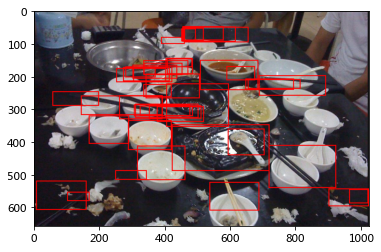

[   0.053677    0.041538     0.03847    0.023955     0.01901   0.0037626   0.0019851   0.0017311   0.0011086]


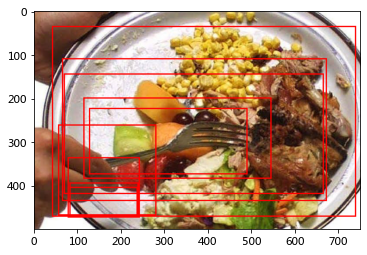

[  0.0065216   0.0012937]


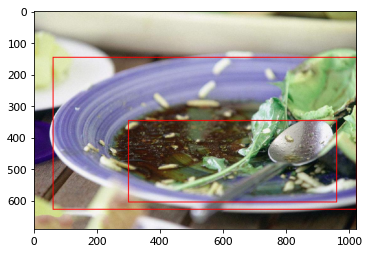

[    0.10242   0.0095438   0.0043123   0.0031211   0.0024994   0.0023761   0.0021489   0.0021317   0.0014357   0.0012139   0.0011849   0.0011665   0.0010977     0.00102]


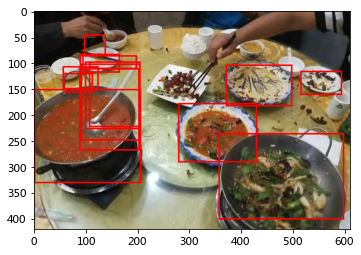

[   0.062535    0.039532    0.030248    0.015043   0.0063104   0.0063026   0.0060098   0.0046951   0.0045447   0.0040048   0.0038321   0.0029494   0.0026091   0.0024196    0.002219   0.0020514   0.0018853   0.0017862    0.001702   0.0015058   0.0012901]


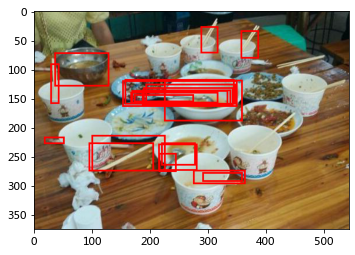

[  0.0096021   0.0069272   0.0061777   0.0038636   0.0034122   0.0030771   0.0029989   0.0028829   0.0025035   0.0023538   0.0020163   0.0018027   0.0016819    0.001597   0.0015532   0.0014771   0.0014293   0.0013642    0.001307   0.0012924   0.0011994   0.0011178    0.001009]


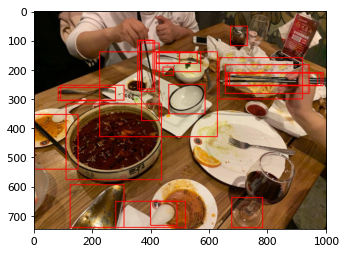

[   0.052093]


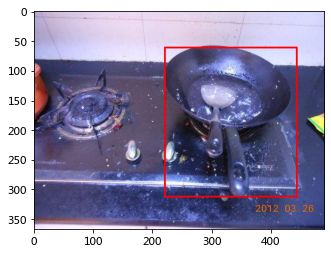

[    0.79268   0.0042252   0.0014169   0.0012686   0.0010759]


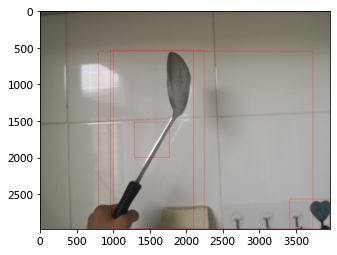

[    0.56679     0.20671     0.13301     0.10293    0.028914    0.026654    0.023139    0.011759   0.0073593   0.0060088   0.0046663   0.0044414   0.0032119   0.0031593   0.0027427   0.0027169   0.0026854   0.0020042   0.0019603   0.0016391   0.0013851   0.0012908   0.0012838   0.0012293   0.0011368]


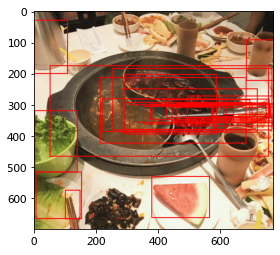

[   0.029733    0.020017    0.019689   0.0091023   0.0074569   0.0049818   0.0034181   0.0030999   0.0020777   0.0018141   0.0017783   0.0017778   0.0017485   0.0016336   0.0016074   0.0014527    0.001414   0.0014003    0.001379   0.0013571   0.0012945   0.0012808   0.0012385   0.0012153   0.0011673   0.0011392
   0.0010199]


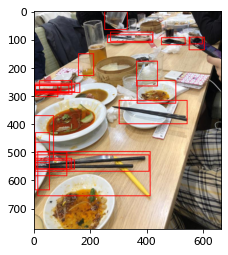

[  0.0025111]


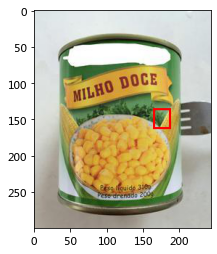

[   0.032134    0.010984    0.010475   0.0090864   0.0040685   0.0038004   0.0036051   0.0026951   0.0025753   0.0019025   0.0016145   0.0014828   0.0014725   0.0014203    0.001414   0.0010494   0.0010155   0.0010051]


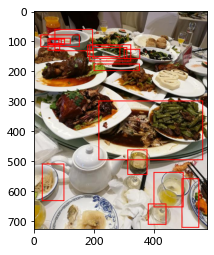

[   0.014046   0.0024877    0.001191]


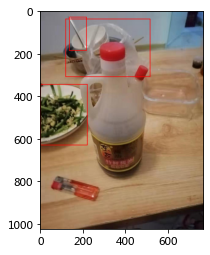

[    0.67425    0.016064    0.010255    0.003414   0.0012998]


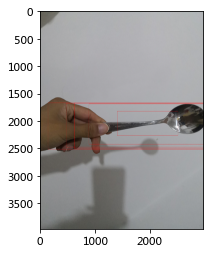

[    0.26812      0.0154     0.01512   0.0059609   0.0031095   0.0023536]


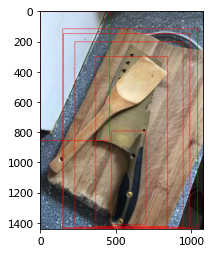

[  0.0023078]


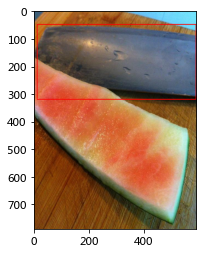

[  0.0016621   0.0014941   0.0013425   0.0011196   0.0010328]


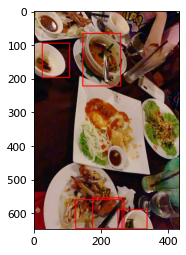

[]


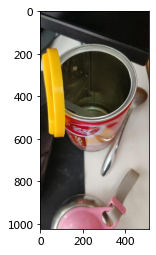

In [109]:
from PIL import Image
from matplotlib import pyplot as plt
from vutils import *
size_level = 'all'

hard_class = 35

num = 0
for i, output in enumerate(outputs):
    predict = np.array(output['pred'])
    conf = np.array(output['conf'])
    target = np.array(output['target'])
    tbox = target[:, 1:]
    tlabel = target[:, 0]
    
    tbox, tlabel = select_with_size(tbox, tlabel, size_label = size_level, input_format='xywh')
    
    path = output['path']

    if hard_class in tlabel:
        #boxes = tbox
        #print(tbox)
        #print(tlabel)
        #print(path)
        #print(output['shapes'])
        #print(output['whwh'])
        #print(output['pred'])
        pboxes = np.array(output['pred'])
        pboxes = pboxes[np.array(output['preid']) == hard_class]
        
        #[conf>0.2]
        conf_cls = conf[np.array(output['preid']) == hard_class]
        print(conf_cls)
        
        pboxes = pboxes
        #print(pboxes[0])
        img = Image.open(path)
        
        boxes = pboxes / np.array(output['whwh'])
        whwh = np.array([img.size[0], img.size[1], img.size[0], img.size[1]])
        #boxes = xywh2xyxy(boxes) * whwh
        boxes = boxes * whwh
        show_box_on_image(img, boxes)
    
        plt.imshow(img)

        plt.show()
        num+=1
#         if num%10==9:
#             break;

In [ ]:
a = np.array([4,34])

34 in a

### Appendix: 测试 读取数据 接口